# 2.2 Validation and Hyperparameter Tuning

Hyperparameter tuning is a critical step in building effective machine learning models. It involves selecting the best set of parameters (such as learning rate, batch size, regularization strength, etc.) that maximize model performance. Validation techniques help us estimate how well our model will generalize to unseen data.

## Learning Objectives

- Understand the difference between training, validation, and test sets.
- Learn common validation strategies (hold-out, k-fold cross-validation).
- Explore hyperparameters and their impact on model performance.
- Implement hyperparameter tuning using TensorFlow and PyTorch.
- Apply these concepts to the MNIST dataset.

---

## Training, Validation, and Test Sets

To evaluate and tune our models, we split the data into three sets:

- **Training set**: Used to fit the model.
- **Validation set**: Used to tune hyperparameters and prevent overfitting.
- **Test set**: Used to assess final model performance.

![Data Splits](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

*Figure: Example of data splits for cross-validation*

---

## Common Validation Strategies


### Hold-Out Validation
- Split the data into training and validation sets (e.g., 80% train, 20% validation).
- Simple and fast, but results may depend on the split.

### K-Fold Cross-Validation
- Split the data into $k$ folds.
- Train the model $k$ times, each time using a different fold as the validation set and the rest as training.
- Average the results for a more robust estimate.

K-fold cross-validation is especially useful for small datasets. For large datasets like MNIST, hold-out validation is often sufficient.

## What Are Hyperparameters?

Hyperparameters are settings that control the learning process and model architecture, but are not learned from the data. Examples include:

- Learning rate

- Batch size

- Number of layers and units

- Regularization strength (L2, Dropout rate)

- Optimizer type

Choosing the right hyperparameters can dramatically affect model performance.

---

## The MNIST Dataset for Hyperparameter Tuning

We will use the MNIST dataset to demonstrate hyperparameter tuning. MNIST consists of 70,000 images of handwritten digits (0-9), each 28x28 pixels. It is widely used for benchmarking classification algorithms.

Let's load and visualize some samples.

Train shape: (60000, 28, 28), Test shape: (10000, 28, 28)


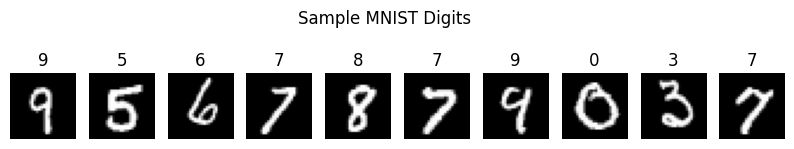

In [2]:
# Load and visualize MNIST dataset
import numpy as np
import matplotlib.pyplot as plt

try:
    from tensorflow.keras.datasets import mnist as tf_mnist
except ImportError:
    tf_mnist = None

if tf_mnist is not None:
    (x_train, y_train), (x_test, y_test) = tf_mnist.load_data()
    print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")
    plt.figure(figsize=(10,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        idx = np.random.randint(0, x_train.shape[0])
        plt.imshow(x_train[idx], cmap='gray')
        plt.axis('off')
        plt.title(str(y_train[idx]))
    plt.suptitle('Sample MNIST Digits')
    plt.show()
else:
    print('TensorFlow not installed. Skipping MNIST visualization.')

---

## Hyperparameter Tuning in TensorFlow

Let's tune the learning rate and batch size for a simple MLP on MNIST using TensorFlow. We'll use the validation set to select the best combination.

In [5]:
# TensorFlow: Hyperparameter tuning for learning rate and batch size
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Split train into train/val
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train2 = x_train[:-10000]
y_train2 = y_train[:-10000]

def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

learning_rates = [1e-2, 1e-3, 1e-4]
batch_sizes = [32, 64, 128]
results = {}
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training: lr={lr}, batch_size={bs}")
        model = build_model()
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(x_train2, y_train2, epochs=5, batch_size=bs, validation_data=(x_val, y_val), verbose=0)
        val_acc = history.history['val_accuracy'][-1]
        results[(lr, bs)] = val_acc
        print(f"Validation accuracy: {val_acc:.4f}")

print("\nBest hyperparameters:")
best = max(results, key=results.get)
print(f"Learning rate: {best[0]}, Batch size: {best[1]}, Validation accuracy: {results[best]:.4f}")

Training: lr=0.01, batch_size=32
Validation accuracy: 0.9660
Training: lr=0.01, batch_size=64
Validation accuracy: 0.9660
Training: lr=0.01, batch_size=64
Validation accuracy: 0.9626
Training: lr=0.01, batch_size=128
Validation accuracy: 0.9626
Training: lr=0.01, batch_size=128
Validation accuracy: 0.9688
Training: lr=0.001, batch_size=32
Validation accuracy: 0.9688
Training: lr=0.001, batch_size=32
Validation accuracy: 0.9732
Training: lr=0.001, batch_size=64
Validation accuracy: 0.9732
Training: lr=0.001, batch_size=64
Validation accuracy: 0.9717
Training: lr=0.001, batch_size=128
Validation accuracy: 0.9717
Training: lr=0.001, batch_size=128
Validation accuracy: 0.9730
Training: lr=0.0001, batch_size=32
Validation accuracy: 0.9730
Training: lr=0.0001, batch_size=32
Validation accuracy: 0.9603
Training: lr=0.0001, batch_size=64
Validation accuracy: 0.9603
Training: lr=0.0001, batch_size=64
Validation accuracy: 0.9538
Training: lr=0.0001, batch_size=128
Validation accuracy: 0.9538
Tra

---

## Hyperparameter Tuning in PyTorch

Let's perform a similar hyperparameter search in PyTorch, tuning the learning rate and batch size for an MLP on MNIST.

In [6]:
# PyTorch: Hyperparameter tuning for learning rate and batch size
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.83 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(lr, batch_size, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    return val_acc

learning_rates = [1e-2, 1e-3, 1e-4]
batch_sizes = [32, 64, 128]
results = {}
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training: lr={lr}, batch_size={bs}")
        val_acc = train_model(lr, bs)
        results[(lr, bs)] = val_acc
        print(f"Validation accuracy: {val_acc:.4f}")

print("\nBest hyperparameters:")
best = max(results, key=results.get)
print(f"Learning rate: {best[0]}, Batch size: {best[1]}, Validation accuracy: {results[best]:.4f}")

Training: lr=0.01, batch_size=32


/media/kmom/Data/github/kmom88/zero-to-hero-AI/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Validation accuracy: 0.9681
Training: lr=0.01, batch_size=64
Validation accuracy: 0.9615
Training: lr=0.01, batch_size=128
Validation accuracy: 0.9615
Training: lr=0.01, batch_size=128
Validation accuracy: 0.9682
Training: lr=0.001, batch_size=32
Validation accuracy: 0.9682
Training: lr=0.001, batch_size=32
Validation accuracy: 0.9738
Training: lr=0.001, batch_size=64
Validation accuracy: 0.9738
Training: lr=0.001, batch_size=64
Validation accuracy: 0.9726
Training: lr=0.001, batch_size=128
Validation accuracy: 0.9726
Training: lr=0.001, batch_size=128
Validation accuracy: 0.9691
Training: lr=0.0001, batch_size=32
Validation accuracy: 0.9691
Training: lr=0.0001, batch_size=32
Validation accuracy: 0.9430
Training: lr=0.0001, batch_size=64
Validation accuracy: 0.9430
Training: lr=0.0001, batch_size=64
Validation accuracy: 0.9348
Training: lr=0.0001, batch_size=128
Validation accuracy: 0.9348
Training: lr=0.0001, batch_size=128
Validation accuracy: 0.9214

Best hyperparameters:
Learning r

---

## Summary and Practical Recommendations

- Always split your data into training, validation, and test sets to properly evaluate model performance.
- Use validation accuracy/loss to guide hyperparameter selection.
- Try different values for key hyperparameters (learning rate, batch size, regularization strength, etc.).
- For small datasets, use k-fold cross-validation for robust estimates.
- For large datasets, hold-out validation is usually sufficient.
- Automated tools (e.g., GridSearchCV, KerasTuner, Ray Tune) can help scale hyperparameter search.

---